<a href="https://colab.research.google.com/github/SampMark/Machine-Learn/blob/main/SVM_Applied_to_Transaction_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelagem *Support Vector Machines* (SVM) para detecção de fraudes em transações de crédito/bancária**.


Modelos de aprendizado de máquina, como [Árvores de Decisão](https://github.com/SampMark/Machine-Learn/blob/main/Decision_Trees.ipynb) e [Máquinas de Vetores de Suporte (SVM)](https://github.com/SampMark/Machine-Learn/blob/main/SVM_Support_Vector_Machines.ipynb) têm sido amplamente utilizados na detecção de fraudes em transações com cartão de crédito ou bancárias, trata-se de um desafio devido ao volume significativo de dados e à natureza dinâmica das fraudes.

Em especial, o SVM, é uma ferramenta poderosa na detecção de fraudes, mas a modelagem exige uma atenção especial para garantir a eficácia de sua aplicação, devido aos seguintes desafios:

1. **O Desafio dos Dados Desbalanceados:**

  Em cenários de detecção de fraudes, os conjuntos de dados geralmente são desbalanceados, com uma quantidade muito maior de transações legítimas em comparação com as fraudulentas.  Isso pode levar a um viés do modelo, que tende a classificar a maioria das transações como legítimas, ignorando as fraudes.

2. **Mitigando o Desbalanceamento:**

Para lidar com esse problema, são empregadas técnicas como:

  * **Pesos Ajustados:** atribuir pesos maiores às instâncias fraudulentas durante o treinamento, tornando-as mais relevantes para o modelo.
  * **Reamostragem:**  balancear o conjunto de dados através de técnicas como _oversampling_ (replicar instâncias da classe minoritária) ou _undersampling_ (remover instâncias da classe majoritária).

3. **Escolha do Kernel e Otimização:**

  A escolha da função kernel adequada é crucial para o desempenho do SVM.  Kernels não lineares, como o RBF (Radial Basis Function), podem ser mais eficazes para capturar relações complexas nos dados de fraude.  Além disso, a otimização de hiperparâmetros, como o custo de regularização (C), é essencial para evitar overfitting e garantir a generalização do modelo.

4. **Considerações Adicionais:**

  * **Interpretabilidade:**  como os SVM são modelos complexos, técnicas como a análise de vetores de suporte podem fornecer insights sobre as características mais relevantes para a detecção de fraudes.
  * **Escalabilidade:**  em conjuntos de dados muito grandes, os SVM são computacionalmente intensivos.  Nesses casos, otimizações e algoritmos alternativos podem ser considerados.

O modelo SVMs é uma ferramenta valiosa na detecção de fraudes, mas sua aplicação requer cuidado na escolha do kernel, otimização de hiperparâmetros e tratamento de dados desbalanceados.  Ao abordar esses desafios, as SVMs podem auxiliar na identificação de padrões complexos e na proteção contra atividades fraudulentas.

## **Instalando e importando bibliotecas Python**

---



In [16]:
# Aprendizado de Máquina
!pip install scikit-learn
!pip install snapml # Instala SnapML para aprendizado de máquina em alta velocidade (aceleração de hardware)

# Manipulação de Dados
!pip install pandas
!pip install numpy

# Visualização de Dados
!pip install matplotlib
%matplotlib inline

#Aceleração por GPU
!pip install -U cupy-cuda11x

# Integração com Google Drive
!pip install PyDrive

!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.7 MB/s eta 0:00:00


In [3]:
# Implementação do ambiente para análise de dados e aprendizado de máquina.
# Importa a função de impressão compatível com versões futuras do Python (Python 3+)
from __future__ import print_function
from google.colab import drive

# Importa bibliotecas matemáticas e de análise de dados
import numpy as np  # Para se trabalhar com arrays e operações matemáticas
import pandas as pd  # Para manipulação e análise de dados em tabelas

import scipy.optimize as opt
# Importa a biblioteca de visualização
import matplotlib.pyplot as plt  # Para criar gráficos e visualizações

# Importa bibliotecas adicionais
import time  # Medir o tempo de execução
import warnings  # Gerenciar e suprimir avisos
# import cupy as cp

## **Importando e explorando a base de dados**

---



In [4]:
# Download arquivo CSV do Colab
raw_data = pd.read_csv('/content/drive/MyDrive/my_colab_notebooks/data/creditcard.csv', sep=';', encoding='UTF-8')
# Imprimir a estrutura do arquivo
print(f"Há \033[1;34m{len(raw_data):,}\033[0m linhas de observação nos dados de fraude em cartão de crédito.")
print("Há " + str(len(raw_data.columns)) + " colunas de variáveis na base de dados.")

Há 284,807 linhas de observação nos dados de fraude em cartão de crédito.
Há 31 colunas de variáveis na base de dados.


In [5]:
# Visualiza no formato de tabela o cabeçalho e as primeiras 5 colunas do dataset 'raw_data'
display(raw_data.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Verificar os tipos de dados das colunas do DataFrame
raw_data.dtypes

,0
Time,float64
V1,float64
V2,float64
V3,float64
V4,float64
V5,float64
V6,float64
V7,float64
V8,float64
V9,float64


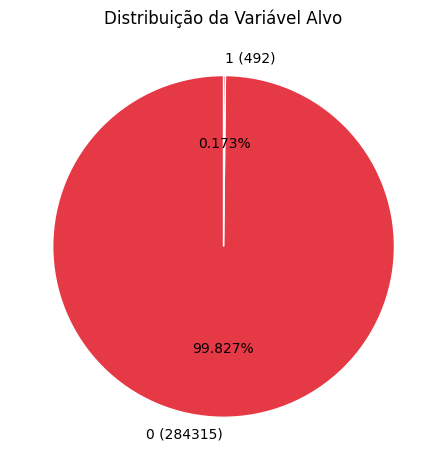

In [7]:
# Obtém os rótulos únicos da variável de destino (classe) e seus tamanhos correspondentes
labels = raw_data.Class.unique()  # Rótulos únicos da variável "Class"
sizes = raw_data.Class.value_counts().values  # Contagem de observações por classe

# Ordena os rótulos e tamanhos para consistência (opcional)
labels, sizes = zip(*sorted(zip(labels, sizes), key=lambda x: x[0]))

# Cria o gráfico de pizza
fig, ax = plt.subplots()
colors = ['#e63946']
ax.pie(
    sizes,
    labels=[f"{label} ({size})" for label, size in zip(labels, sizes)],  # Rótulos incluem contagem
    autopct='%1.3f%%',  # Formato das porcentagens com 2 casas decimais
    colors=colors,
    startangle=90,  # Inicia o gráfico no ângulo de 90º para consistência
    wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}  # Melhora o design
)

# Configurações adicionais
ax.set_title('Distribuição da Variável Alvo', fontsize=12)
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()  # Exibe o gráfico

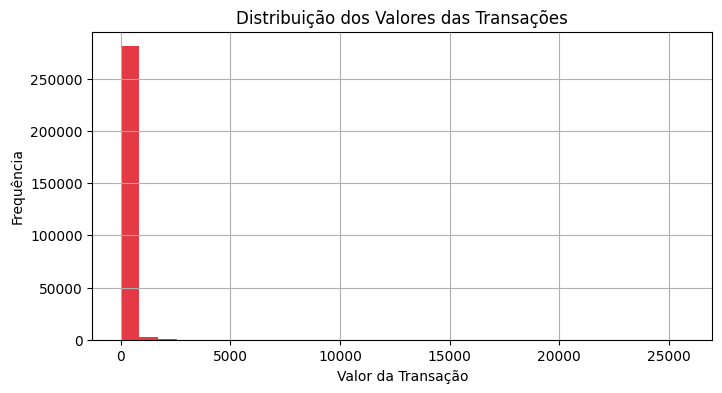

Valor Mínimo das Transações: 0.00
Valor Máximo das Transações: 25691.1600
Valor Médio das Transações: 88.3496
Desvio Padrão: 250.1201
90º Percentil: 203.00


In [8]:
# Plota um histograma dos valores das transações
plt.figure(figsize=(8, 4))  # Define o tamanho da figura
plt.hist(raw_data['Amount'], bins=30, color='#e63946')
plt.xlabel('Valor da Transação')
plt.ylabel('Frequência')
plt.title('Distribuição dos Valores das Transações')
plt.grid(True)
plt.show()

# Calcula e imprime estatísticas descritivas
min_amount = raw_data['Amount'].min()  # Valor mínimo
max_amount = raw_data['Amount'].max()  # Valor máximo
mean_amount = raw_data['Amount'].mean()  # Média
std_amount = raw_data['Amount'].std()  # Desvio padrão
percentile_90 = raw_data['Amount'].quantile(0.9)  # 90º percentil

print(f"Valor Mínimo das Transações: {min_amount:.2f}")
print(f"Valor Máximo das Transações: {max_amount:.4f}")
print(f"Valor Médio das Transações: {mean_amount:.4f}")
print(f"Desvio Padrão: {std_amount:.4f}")
print(f"90º Percentil: {percentile_90:.2f}")

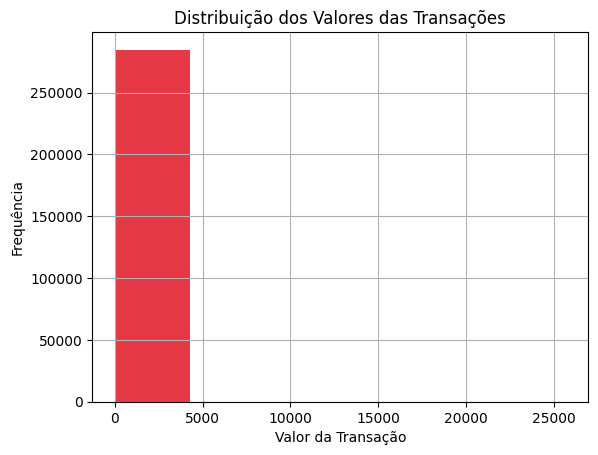

Valor mínimo: 0.0
Valor máximo: 25691.16
98% das transações têm um valor menor ou igual a: 691.0576000000001


In [9]:
# Plota um histograma dos valores das transações
plt.hist(raw_data.Amount.values, 6, histtype='bar', facecolor='#e63946')
plt.hist(raw_data.Amount.values, bins=50, histtype='bar', facecolor='#e63946')
plt.xlabel("Valor da Transação")
plt.ylabel("Frequência")
plt.title("Distribuição dos Valores das Transações")
plt.grid(True)
plt.show()

# Calcula e imprime estatísticas descritivas
print("Valor mínimo:", np.min(raw_data.Amount.values))
print("Valor máximo:", np.max(raw_data.Amount.values))
print("98% das transações têm um valor menor ou igual a:", np.percentile(raw_data.Amount.values, 98))

## **Pré-processamento do Conjunto de Dados**

---



Nesta subseção, os dados serão preparados para o treinamento. O pré-processamento serve para melhorar o desempenho do modelo, especialmente modelos lineares, o escalonamento/normalização é normalmente útil para acelerar a convergência de treinamento.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

# Padroniza as features (colunas de 1 a 29) para terem média 0 e desvio padrão 1
raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(raw_data.iloc[:, 1:30])
raw_data.isnull().sum()

# Converte o DataFrame em uma matriz NumPy
data_matrix = raw_data.values

# Cria a matriz de features X (excluindo a coluna Time)
X = data_matrix[:, 1:30]

# Cria o vetor de labels y
y = data_matrix[:, 30]

# Normaliza as features usando a norma L1
X = normalize(X, norm="l1")

# Imprime as dimensões da matriz de features e do vetor de labels
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (284807, 29) y.shape= (284807,)


**1. Padronização dos dados do DataFrame** `raw_data`:
* `raw_data.iloc[:, 1:30]`: Seleciona todas as linhas e as colunas de 1 a 29 (excluindo a primeira coluna dos identificadores).
* `StandardScaler()`: Cria um objeto StandardScaler  usado para padronização, isto é, transforma os dados para que tenham média zero e desvio padrão igual a 1.
* .`fit_transform()`: Ajusta o StandardScaler aos dados selecionados (calcula a média e o desvio padrão) e, em seguida, transforma os dados aplicando a padronização.
* `data_matrix = raw_data.values`: Converte o DataFrame `raw_data` em uma matriz NumPy (`data_matrix`) para facilitar a manipulação dos dados no aprendizado de máquina.

**2. Separação de features e labels**:  As *features* são as variáveis ​​de entrada usadas para treinar o modelo e os os *labels* são os valores que o modelo de aprendizado de máquina deve prever.

* `X = data_matrix[:, 1:30]`: Cria a matriz de features X, selecionando todas as linhas e as colunas de 1 a 29 da data_matrix.
* `y = data_matrix[:, 30]`: Cria o vetor de labels y selecionando todas as linhas e a coluna 30 da data_matrix.

**3. Normalização dos dados**:

* `X = normalize(X, norm="l1")`: Aplica a normalização L1 às features X.
* `normalize(X, norm="l1")`: Aplica a função do scikit-learn que normaliza os dados, `norm="l1"` especifica que a norma L1 deve ser usada, o que significa que a soma dos valores absolutos de cada linha será igual a 1.

**4. Impressão das dimensões**: para verificar se os dados foram processados ​​corretamente é feita a impressão das dimensões (número de linhas e colunas) da matriz de features X e do vetor de labels y.

## **Divisão do Conjunto de Dados em Treinamento/Teste**

---



In [14]:
from sklearn.model_selection import train_test_split

# Divide os dados em conjuntos de treinamento e teste
# Especifica que 30% dos dados serão usados para teste e os 70% restantes para treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Imprime as dimensões dos conjuntos de treinamento
# O número de linhas e colunas da matriz de features de treinamento (X_train) e do vetor de labels de treinamento (y_train)
print('Conjunto de treino X =', X_train.shape, 'Conjunto de treino y =', y_train.shape)

# Imprime as dimensões dos conjuntos de teste, da matriz de features de teste (X_test) e do vetor de labels de teste (y_test)
print('Conjunto de teste X =', X_test.shape, 'Conjunto de teste y =', y_test.shape)

Conjunto de treino X = (199364, 29) Conjunto de treino y = (199364,)
Conjunto de teste X = (85443, 29) Conjunto de teste y = (85443,)


Nesta etapa crucial no desenvolvimento de modelos, os dados foram divididos em conjuntos de treinamento e teste, o que nos permite avaliar o desempenho do modelo em dados não vistos durante o treinamento.

* `train_test_split(X, y, ...)`: Esta função do scikit-learn divide os dados em conjuntos de treinamento e teste.
* `X`: A matriz de features (variáveis de entrada).
* `y`: O vetor de labels (variável de saída).
* `test_size=0.3`: Especifica que 30% dos dados serão usados para teste e os 70% restantes para treinamento.
* `random_state=42`: Define uma semente para o gerador de números aleatórios, garantindo que a divisão dos dados seja reproduzível, ao executar o código novamente com a mesma semente, se obterá a mesma divisão.
* `stratify=y`: garante que a proporção de classes (valores únicos em y) seja mantida nos conjuntos de treinamento e teste. É especialmente útil quando se lida com dados desbalanceados, quando uma classe é muito mais frequente do que as outras.

As variáveis que armazenam os conjuntos de dados resultantes são:
* `X_train`: Matriz de features para treinamento.
* `X_test`: Matriz de features para teste.
* `y_trai`n: Vetor de labels para treinamento.
* `y_test`: Vetor de labels para teste.

## **Modelagem do _Support Vector Machine_ (SVM) com o Snap ML**

In [17]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from snapml import SupportVectorMachine
from sklearn.model_selection import train_test_split

# Pipeline com pré-processamento e modelagem SVM
fraudDetection = Pipeline([
    ('scaler', StandardScaler()),  # Etapa de padronização dos dados
    ('pca', PCA(n_components=0.95)),  # Preserva 95% da variância
    ('svm', SupportVectorMachine(
        kernel='rbf',              # Kernel radial basis function
        gamma=0.001,               # Controla a influência dos pontos de dados
        # penalty='l2',              # Regularização L2
        # loss='hinge',              # Perda hinge (ótima para SVM)
        # dual=False,                # Resolve o problema primal (mais eficiente para conjuntos pequenos)
        # C=1.0,                     # Regularização (maior = menos regularização)
        # tol=1e-4,                  # Critério de tolerância para convergência
        fit_intercept=False,       # Não calcula o intercepto; os dados devem ser centrados
        class_weight='balanced',   # Balanceia automaticamente classes desbalanceadas
        random_state=42,           # Semente para reprodutibilidade
        # max_iter=1000,             # Número máximo de iterações
        # verbose=0,                 # Desativa logs de execução
        # use_gpu=True,              # Aceleração via GPU, se disponível
        # enable_sparse=False        # Desativa representações esparsas
    ))
])

# Exemplo de ajuste do pipeline com dados de treinamento
fraudDetection.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('svm',
                 SupportVectorMachine(class_weight='balanced',
                                      device_ids=array([], dtype=uint32),
                                      gamma=0.001, kernel='rbf',
                                      random_state=42))])

In [18]:
# Prever os dados de teste, aplicando o pipeline completo
y_pred = fraudDetection.predict(X_test)
y_pred

array([1., 0., 0., ..., 0., 0., 0.])

In [19]:
print("As primeiras 100 previsões são:", y_pred[:100])

As primeiras 100 previsões são: [1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 1.]


## **Análise da Acurácia do Modelo e da curva ROC-AUC (Área Sob a Curva ROC)**

Acurácia do modelo:   0.8112
ROC-AUC score:   0.8926


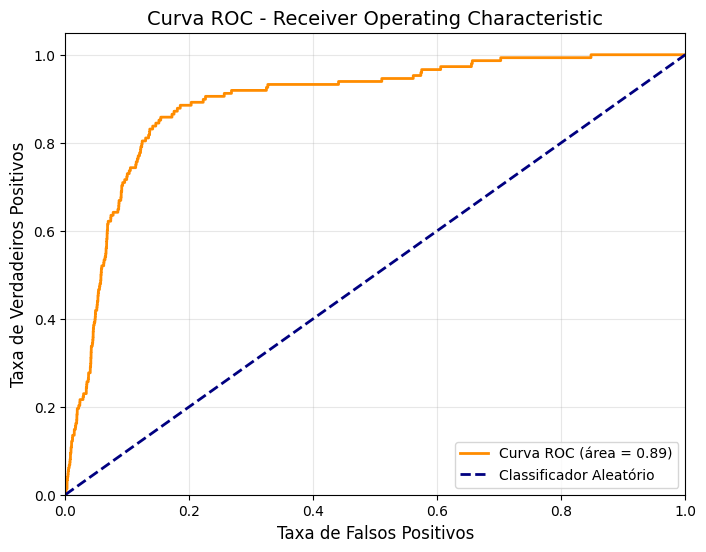

In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# A acurácia é a proporção de predições corretas em relação ao total de predições
accuracy = fraudDetection.score(X_test, y_test)
print("Acurácia do modelo:   {0:.4f}".format(accuracy))

# Calcula a área sob a curva ROC (Receiver Operating Characteristic),
# para avalia a capacidade do modelo de distinguir entre as classes (fraude e não fraude).
acc_snapml  = roc_auc_score(y_test, fraudDetection.decision_function(X_test))
print("ROC-AUC score:   {0:.4f}".format(acc_snapml))

# Obter os scores da função de decisão
y_scores = fraudDetection.decision_function(X_test)

# Calcular a curva ROC e a área sob a curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Classificador Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curva ROC - Receiver Operating Characteristic', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

A curva _Receiver Operating Characteristic_ (ROC) reflete a relação entre a Taxa de Verdadeiros Positivos (Recall) e a Taxa de Falsos Positivos. A curva laranja está significativamente acima da linha azul (classificador aleatório), sugerindo um bom desempenho.

* **Acurácia do Modelo** = 81,12%, representa a proporção de previsões corretas em relação ao total de previsões. Embora pareça razoável, em problemas de classes desbalanceadas, como na detecção de fraudes, a acurácia por si só pode se mostrar uma métrica enganosa. Porque a classe "Sem-Fraude" é significativamente maior, inflando a "acurácia", já que o modelo pode estar prevendo a classe majoritária com maior frequência.

* **ROC-AUC** (Área Sob a Curva ROC) = 89,26%: o ROC-AUC mede a capacidade do modelo em distinguir entre as classes, indicando uma boa habilidade na separação entre as classes "Fraude" e "Sem-Fraude". Quanto mais próximo de 1, melhor.

Matriz de Confusão:
[[69180 16115]
 [   17   131]]


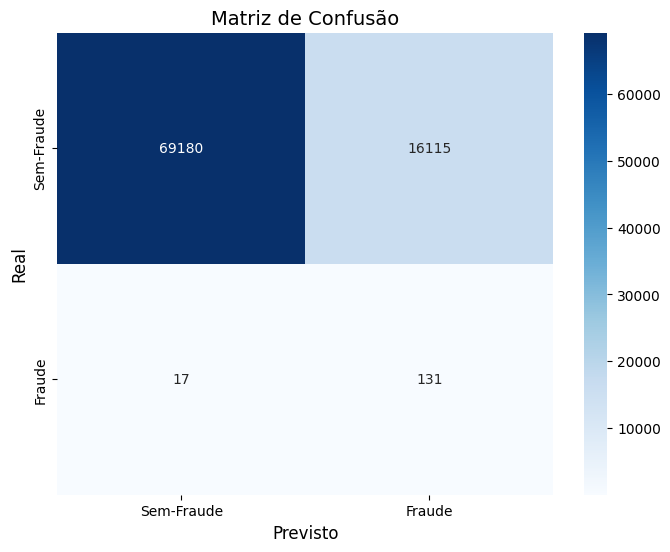


Relatório de Classificação:
              precision    recall  f1-score   support

  Sem-Fraude     0.9998    0.8111    0.8956     85295
      Fraude     0.0081    0.8851    0.0160       148

    accuracy                         0.8112     85443
   macro avg     0.5039    0.8481    0.4558     85443
weighted avg     0.9980    0.8112    0.8941     85443


Overall F1 Score: 0.0160
Jaccard Score: 0.0081
Hinge Loss:   0.9910


In [24]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, jaccard_score, hinge_loss
import seaborn as sns

def plot_confusion_matrix(cm, labels, title="Matriz de Confusão"):
    """
    Plota a matriz de confusão.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
    plt.xlabel('Previsto', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()

def evaluate_model(y_test, y_pred, labels=["Sem-Fraude", "Fraude"], model=fraudDetection):
    """
    Avalia o modelo com matriz de confusão, classification report,
    F1 score e Jaccard score.
    """
    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão:")
    print(cm)
    plot_confusion_matrix(cm, labels)

    # Classification Report
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=labels, digits=4))

    # F1 Score (overall)
    f1 = f1_score(y_test, y_pred, average='binary')
    print(f"\nOverall F1 Score: {f1:.4f}")

    # Jaccard Score
    jaccard = jaccard_score(y_test, y_pred)
    print(f"Jaccard Score: {jaccard:.4f}")

    # Hinge loss for Snap ML SVM
    # snapml_hinge_loss = hinge_loss(y_test, snapml_svm.decision_function(X_test))

    X_test_pca = model.named_steps['pca'].transform(X_test)  # Apply PCA transformation
    snapml_hinge_loss = hinge_loss(y_test, model.named_steps['svm'].decision_function(X_test_pca))
    print("Hinge Loss:   {0:.4f}".format(snapml_hinge_loss))

# Avaliação do modelo
evaluate_model(y_test, y_pred, labels=["Sem-Fraude", "Fraude"])


## **Matriz de Confusão**

* **Falsos Positivos** (16115): o modelo gerou um número significativo de transações "Sem-Fraude"  classificadas erroneamente como "Fraude". Esse comportamento é indesejável em sistemas de detecção de fraude, pois pode levar a alarmes falsos, impactando negativamente a experiência do cliente.

* **Falsos Negativos** (17): apesar de pequeno, cada caso de fraude não detectado pode ser um evento crítico, representando ainda que há falha do modelo na previsão de transações fraudulentas.

## **Desempenho Geral do Modelo**

* **Accuracy** = 81.12%, apesar de alta, a Acurácia Geral pode ser enganosa em cenários de classes desbalanceadas. A classe "Sem-Fraude" domina o conjunto de dados, logo o modelo tenderá a priorizar prever corretamente esta classe, enquanto negligencia "Fraude".

* **Overall F1 Score** = 0.0160, F1 Score está extremamente baixo para a classe de interesse "Fraude", logo o modelo tem grande dificuldade em equilibrar precisão e recall para esta classe.

### **Classe "Sem-Fraude"**

* **Precision** = 99.98%, a maioria das previsões feitas para "Sem-Fraude" está correta, o que é esperado, devido o desbalanceamento.

* **Recall** (Revocação) = 81.11%, o modelo está capturando apenas 81% dos casos "Sem-Fraude", indicando que uma fração considerável destas está sendo erroneamente classificada como "Fraude".

### **Classe "Fraude"**

* **Precision** = 0.81%, muitas previsões de "Fraude" estão incorretas, indicando alto número de falsos positivos.

* **Recall** (Revocação) = 88.51%, o modelo consegue capturar a maioria dos casos de fraude (131 de 148), o que é positivo.

### **Pontuações Complementares**

* **Jaccard Score** (Fraude) = 0.0081, a interseção entre previsões corretas e totais é muito baixa, indicando dificuldade do modelo no alinhamento das previsões com os rótulos verdadeiros.

* **Hinge Loss** = 0.9910, a perda hinge elevada sugere que o modelo está deixando ainda a desejar em separar adequadamente as classes.

### **Conclusões**

O alto número de falsos positivos sugere que o modelo não está separando bem as classes. A classe "Fraude" é extremamente sub-representada em comparação com "Sem-Fraude", por isto o modelo está priorizando o _recall_ (revocação) da classe "Fraude" em detrimento da precisão.

## **Otimização de Hiperparâmetros**

A otimização visa encontrar os melhores valores para os hiperparâmetros de um modelo, buscar valores "corretos" pode melhorar significativamente o seu desempenho.

Os hiperparâmetros são diferentes dos parâmetros do modelo (como pesos ou coeficientes), que são aprendidos durante o treinamento. A otimização de hiperparâmetros envolve testar diferentes combinações para determinar quais fornecem o melhor desempenho.

A função `RandomizedSearchCV` (Busca Aleatória) testa combinações aleatórias de hiperparâmetros dentro de um espaço definido. Não garantindo encontrar a melhor combinação, mas é uma boa aproximação para problemas com muitas variáveis. Sendo mais rápido e eficiente para espaços de busca grandes.



In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from snapml import SupportVectorMachine

# Definir o espaço de busca (valores contínuos são suportados)
param_distributions = {
    'regularizer': uniform(0.1, 100),     # 'regularizer' for Snap ML, instead of 'C'
    'gamma': uniform(0.001, 0.1),  # Valores contínuos de gamma entre 0.001 e 0.1
    'kernel': ['rbf']
}

# Inicializar o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=SupportVectorMachine(), param_distributions=param_distributions,
                                   n_iter=50, cv=5, verbose=1, scoring='accuracy', random_state=42)

# Treinar com diferentes combinações
random_search.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print("Melhores Hiperparâmetros:", random_search.best_params_)
print("Melhor Pontuação:", random_search.best_score_)

# Avaliação no conjunto de teste
best_model = random_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Acurácia no Teste:", accuracy)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores Hiperparâmetros: {'gamma': 0.03845401188473625, 'kernel': 'rbf', 'regularizer': 95.17143064099162}
Melhor Pontuação: 0.998274512045246
Acurácia no Teste: 0.9982678510820079


In [33]:
# Pipeline com pré-processamento e modelagem SVM
fraudDetectionOptimized = Pipeline([
    ('scaler', StandardScaler()),  # Etapa de padronização dos dados
    ('pca', PCA(n_components=0.95)),  # Preserva 95% da variância
    ('svm', SupportVectorMachine(
        kernel='rbf',              # Kernel radial basis function
        gamma=0.03845401188473625,   # Controla a influência dos pontos de dados
        # penalty='l2',              # Regularização L2
        # loss='hinge',              # Perda hinge (ótima para SVM)
        # dual=False,                # Resolve o problema primal (mais eficiente para conjuntos pequenos)
        regularizer=95.17143064099162, # Regularização (maior = menos regularização)
        # tol=1e-4,                  # Critério de tolerância para convergência
        fit_intercept=False,       # Não calcula o intercepto; os dados devem ser centrados
        class_weight='balanced',   # Balanceia automaticamente classes desbalanceadas
        random_state=42,           # Semente para reprodutibilidade
        # max_iter=1000,             # Número máximo de iterações
        # verbose=0,                 # Desativa logs de execução
        # use_gpu=True,              # Aceleração via GPU, se disponível
        # enable_sparse=False        # Desativa representações esparsas
    ))
])

# Exemplo de ajuste do pipeline com dados de treinamento
fraudDetectionOptimized.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('svm',
                 SupportVectorMachine(class_weight='balanced',
                                      device_ids=array([], dtype=uint32),
                                      gamma=0.03845401188473625, kernel='rbf',
                                      random_state=42,
                                      regularizer=95.17143064099162))])

Acurácia do modelo:   0.8193
ROC-AUC score:   0.9188


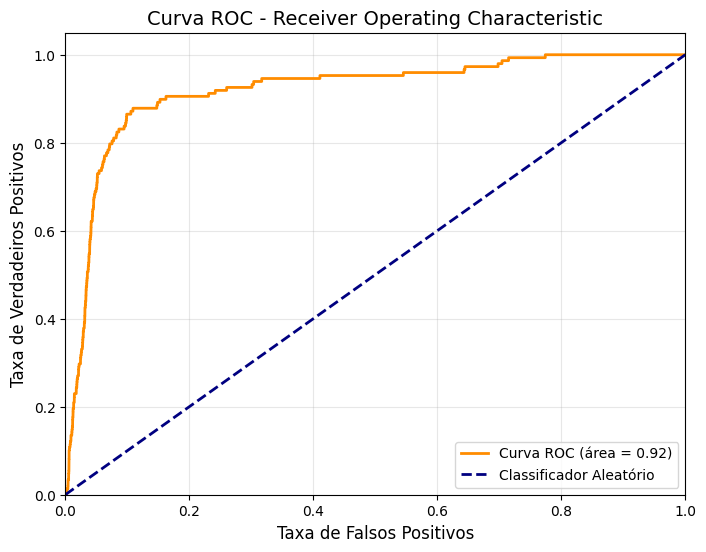

In [34]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# A acurácia é a proporção de predições corretas em relação ao total de predições
accuracy = fraudDetectionOptimized.score(X_test, y_test)
print("Acurácia do modelo:   {0:.4f}".format(accuracy))

# Calcula a área sob a curva ROC (Receiver Operating Characteristic),
# para avalia a capacidade do modelo de distinguir entre as classes (fraude e não fraude).
acc_snapml  = roc_auc_score(y_test, fraudDetectionOptimized.decision_function(X_test))
print("ROC-AUC score:   {0:.4f}".format(acc_snapml))

# Obter os scores da função de decisão
y_scores = fraudDetectionOptimized.decision_function(X_test)

# Calcular a curva ROC e a área sob a curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Classificador Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curva ROC - Receiver Operating Characteristic', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Matriz de Confusão:
[[69180 16115]
 [   17   131]]


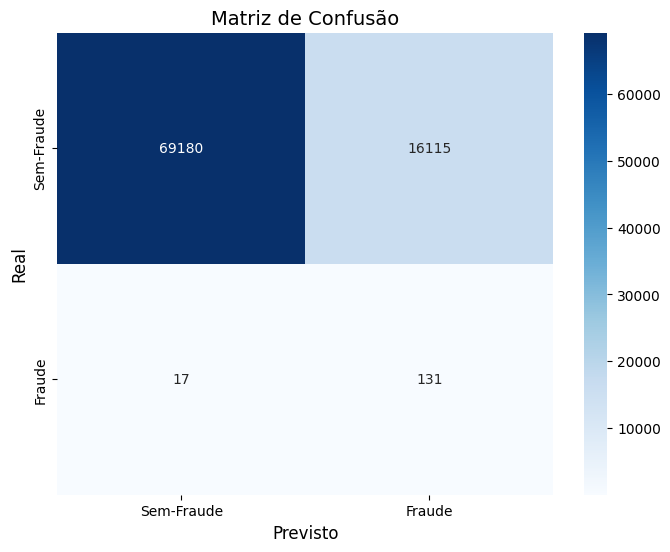


Relatório de Classificação:
              precision    recall  f1-score   support

  Sem-Fraude     0.9998    0.8111    0.8956     85295
      Fraude     0.0081    0.8851    0.0160       148

    accuracy                         0.8112     85443
   macro avg     0.5039    0.8481    0.4558     85443
weighted avg     0.9980    0.8112    0.8941     85443


Overall F1 Score: 0.0160
Jaccard Score: 0.0081
Hinge Loss:   1.7199


In [35]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, jaccard_score, hinge_loss
import seaborn as sns

def plot_confusion_matrix(cm, labels, title="Matriz de Confusão"):
    """
    Plota a matriz de confusão.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
    plt.xlabel('Previsto', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()

def evaluate_model(y_test, y_pred, labels=["Sem-Fraude", "Fraude"], model=fraudDetectionOptimized):
    """
    Avalia o modelo com matriz de confusão, classification report,
    F1 score e Jaccard score.
    """
    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão:")
    print(cm)
    plot_confusion_matrix(cm, labels)

    # Classification Report
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=labels, digits=4))

    # F1 Score (overall)
    f1 = f1_score(y_test, y_pred, average='binary')
    print(f"\nOverall F1 Score: {f1:.4f}")

    # Jaccard Score
    jaccard = jaccard_score(y_test, y_pred)
    print(f"Jaccard Score: {jaccard:.4f}")

    # Hinge loss for Snap ML SVM
    # snapml_hinge_loss = hinge_loss(y_test, snapml_svm.decision_function(X_test))

    X_test_pca = model.named_steps['pca'].transform(X_test)  # Apply PCA transformation
    snapml_hinge_loss = hinge_loss(y_test, fraudDetectionOptimized.named_steps['svm'].decision_function(X_test_pca))
    print("Hinge Loss:   {0:.4f}".format(snapml_hinge_loss))

# Avaliação do modelo
evaluate_model(y_test, y_pred, labels=["Sem-Fraude", "Fraude"])

## **Referências**

1. **"Fraud Detection in Credit Card Transactions Using SVM and Random Forest Algorithms"**  
   HUSSAIN, SK Saddam et al. Fraud detection in credit card transactions using SVM and random forest algorithms. In: 2021 Fifth international conference on I-SMAC (IoT in social, mobile, analytics and cloud)(I-SMAC). IEEE, 2021. p. 1013-1017. Disponível em: https://ieeexplore.ieee.org/abstract/document/9640631. Acesso em: 8 nov. 2024.

2. **Machine learning model for credit card fraud detection - a comparative analysis**

   SHARMA, Pratyush et al. Machine learning model for credit card fraud detection - a comparative analysis. Int. Arab J. Inf. Technol., v. 18, n. 6, p. 789-796, 2021. Disponível em: https://iajit.org/portal/images/year2021/no6/19792.pdf Acesso em: 8 nov. 2024.

3. **Snap ML-Accelerated Machine Learning for Big Data**
   POZIDIS, Haris. Snap ML-Accelerated Machine Learning for Big Data (Keynote Abstract). In: 23rd International Conference on Principles of Distributed Systems (OPODIS 2019). Schloss-Dagstuhl-Leibniz Zentrum für Informatik, 2020.
   
3. **"A Comparative Analysis of Credit Card Detection Models"**  
   KIM, Kimberly Chan Li et al. A Comparative Analysis of Credit Card Detection Models. In: International Conference on Educational Technology and Administration. Singapore: Springer Nature Singapore, 2022. p. 201-211.. Disponível em: https://viacarreira.com/referencias-bibliograficas-abnt/. Acesso em: 8 nov. 2024.

3. **"A Comparison Study of Credit Card Fraud Detection: Supervised versus Unsupervised"**  
   Autores não identificados. A Comparison Study of Credit Card Fraud Detection: Supervised versus Unsupervised. Disponível em: https://www.academia.edu/12345678/A_Comparison_Study_of_Credit_Card_Fraud_Detection_Supervised_versus_Unsupervised. Acesso em: 8 nov. 2024.

4. **"Fraud Detection in Credit Card Transaction Using ANN and SVM"**  
   Autores não identificados. Fraud Detection in Credit Card Transaction Using ANN and SVM. Disponível em: https://blog.fastformat.co/referencias-bibliograficas-normas-abnt/. Acesso em: 8 nov. 2024.

5. **"Credit Card Fraud Detection Using SVM, Decision Tree and Random Forest Supervised Machine Learning Algorithms"**  
   Autores não identificados. Credit Card Fraud Detection Using SVM, Decision Tree and Random Forest Supervised Machine Learning Algorithms. Disponível em: https://www.normasabnt.org/referencias-abnt/. Acesso em: 8 nov. 2024.

